# Heatmaps, scatterplots from figures 3D, S3C, S5

### Nicolas A. Gort-Freitas

In [1]:
#import statements

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import scanpy as sc
import scipy.stats as stats
from copy import deepcopy

import sys 
import os

import rz_functions as rz
import rz_utility_spring as srz

from time import time
import seaborn as sns

from adjustText import adjust_text

python version: 3.6.10


## Auxiliary functions

In [2]:
#convert relevant human genes into their mice orthologs

def format_gene_names(g):
    if len(g) == 1:
        return g
    elif g == 'FASLG':
        return 'Fasl'
    elif re.findall(r'-', g): 
        return '-'.join([format_gene_names(substr) for substr in g.split('-')])
    elif re.findall(r'_', g): 
        return '_'.join([format_gene_names(substr) for substr in g.split('_')])
    else:
        return g[0]+g[1:].lower()

In [3]:
# auxiliary function to use on heatmap data if intending to export to excel

def rename_duplicates(old):
    seen = {}
    for x in old:
        if x in seen:
            seen[x] += 1
            yield "%s_%d" % (x, seen[x])
        else:
            seen[x] = 0
            yield x

## Coarse graining dictionaries for cell states

In [4]:
# Coarse grain relevant cell states for each analysis

#Fig 3 / S3
rz_major_dict = {'zi-Ciliated_FOXJI/CAPS': 'Ciliated cells', 'zi-Club_SCGB1A1/BPIFB1': 'Club cells', 'zi-Endo1_PECAM1/CLEC14A/CD34': 'Endothelial cells',
                 'zi-Endo2_CCL14/SELE': 'Endothelial cells', 'zi-Endo3_IL1RL1': 'Endothelial cells', 'zi-Endo4_CCL21/APLN': 'Endothelial cells',
                 'zi-Fibro1_MGP/PTGDS': 'Fibroblasts', 'zi-Fibro2_INMT/MFAP4': 'Fibroblasts', 'zi-Fibro3_TIMP1': 'Fibroblasts','zi-Fibro4_COL6A1/COL6A2': 'Fibroblasts',
                 'zi-Fibro5_FNDC1/COL12A1': 'Fibroblasts',                 'zi-ND_DPP4/CRABP2': 'ND',                 'zi-Pt1A_PRDX1': 'Patient1-specific',
                 'zi-Pt1B_KRT6A/KRT17/S100A2': 'Patient1-specific',                 'zi-Pt1C_SLC2A1/NDRG1': 'Patient1-specific',
                 'zi-Pt1D_MIAT': 'Patient1-specific',                 'zi-Pt1E_KRT19': 'Patient1-specific',                 'zi-Pt1F_GPNMB': 'Patient1-specific',                 'zi-Pt1G_YBX1/SERPINA12': 'Patient1-specific',
                 'zi-Pt1H_KRT16/SPRR2A': 'Patient1-specific',                 'zi-Pt2_RPL36A/NTS': 'Patient2-specific',                 'zi-Pt3A_TFF1/MUC5A': 'Patient3-specific',                 'zi-Pt3B_LAMC2': 'Patient3-specific',
                 'zi-Pt3C_SERPINB2/KRT23': 'Patient3-specific',                 'zi-Pt3D_LYZ/SPINK4': 'Patient3-specific',                 'zi-Pt3E_CLDN4': 'Patient3-specific',                 'zi-Pt3F_MUC2': 'Patient3-specific',
                 'zi-Pt4_DPP4/CRABP2/PCP4': 'Patient4-specific',                 'zi-Pt5A_S100A4/AQPI/FGFBP1': 'Patient5-specific',                 'zi-Pt5B_AC108215.1': 'Patient5-specific',                 'zi-Pt5B_Ly6E/HOPX': 'Patient5-specific',
                 'zi-Pt5B_PIGR/LCN2/AQP3': 'Patient5-specific',                 'zi-Pt6_SPINK5/SCGB3A1': 'Patient6-specific',                 'zi-Pt7A_BPIFA1': 'Patient7-specific',                 'zi-Pt7B_IER5': 'Patient7-specific',
                 'zi-Pt7C_IL17C/COLEC11': 'Patient7-specific',                 'zi-SMC1_ADAMTS1/EGR1': 'Smooth muscle cells',                 'zi-SMC2_MYH11/ACTG2': 'Smooth muscle cells',                 'zi-SMC3_RGS5/NOTCH3': 'Smooth muscle cells',
                 'zi-SMC4_KCNK3': 'Smooth muscle cells',                 'zi-Type I_AGER/CAV1': 'Type I cells',                 'zi-Type II_A_SFTPA1/SFTPD/LAMP3': 'Type II cells',                 'zi-Type II_B_EEF1A1/SFTPB/TPT1': 'Type II cells',
                 'zi-Type II_C_CXCL2/NCOA7/SFTPB': 'Type II cells',                 'zi-bB cells': 'bB cells',                 'zi-bBasophils': 'bBasophils',                 'zi-bMono1': 'bMonocytes',
                 'zi-bMono2': 'bMonocytes',                 'zi-bMono3': 'bMonocytes',
                 'zi-bMonoDC': 'bMonocytes',                 'zi-bMyeloid precursor-like': 'bMyeloid precursor-like',
                 'zi-bNK cells': 'bNK cells',                 'zi-bN1': 'bNeutrophils',
                 'zi-bN2': 'bNeutrophils',                 'zi-bN3': 'bNeutrophils',
                 'zi-bN4': 'bNeutrophils',                 'zi-bN5': 'bNeutrophils',
                 'zi-bN6': 'bNeutrophils',                 'zi-bPlasma cells': 'bPlasma cells',
                 'zi-bPlatelets': 'bPlatelets',                 'zi-bRBC': 'bRBC',
                 'zi-bCD4T1': 'bT cells',                 'zi-bCD4T2': 'bT cells',
                 'zi-bCD8T1': 'bT cells',                 'zi-bCD8T2': 'bT cells',
                 'zi-bpDC': 'bpDC',                 'zi-tB': 'tB cells',
                 'zi-tMast1': 'tMast cells',                 'zi-tMast2': 'tMast cells',
                 'zi-tDC1': 'tDC',                 'zi-tDC2': 'tDC',
                 'zi-tDC3': 'tDC',                 'zi-tMac1': 'tMoMac',
                 'zi-tMac2': 'tMoMac',                 'zi-tMac3': 'tMoMac',
                 'zi-tMac4': 'tMoMac',                 'zi-tMac5': 'tMoMac',
                 'zi-tMac6': 'tMoMac',                 'zi-tMac7': 'tMoMac',
                 'zi-tMac8': 'tMoMac',                 'zi-tMac9': 'tMoMac',
                 'zi-tMacCycl': 'tMoMac',                 'zi-tMono1': 'tMoMac',
                 'zi-tMono2': 'tMoMac',                 'zi-tMono3': 'tMoMac',
                 'zi-tMonoDC': 'tMoMac',                 'zi-tNK1': 'tNK cells',
                 'zi-tNK2': 'tNK cells',                 'zi-tN1': 'tNeutrophils',
                 'zi-tN2': 'tNeutrophils',                 'zi-tN3': 'tNeutrophils',
                 'zi-tN4': 'tNeutrophils',                 'zi-tN5': 'tNeutrophils',
                 'zi-tPC1': 'tPlasma cells',                 'zi-tPC2': 'tPlasma cells',
                 'zi-tPC3': 'tPlasma cells',                 'zi-tPC4': 'tPlasma cells',
                 'zi-tPC5': 'tPlasma cells',                 'zi-tPC6': 'tPlasma cells',
                 'zi-tRBC': 'tRBC',                 'zi-tT1': 'tT cells',
                 'zi-tT2': 'tT cells',                 'zi-tT3': 'tT cells',
                 'zi-tT4': 'tT cells',                 'zi-tT5': 'tT cells',
                 'zi-tT6': 'tT cells',                 'zi-tT7': 'tT cells',
                 'zi-tpDC': 'tDC'}

#Fig S5
rz_major_dict_s5 = {'zi-Ciliated_FOXJI/CAPS': 'Ciliated cells', 'zi-Club_SCGB1A1/BPIFB1': 'Club cells', 'zi-Endo1_PECAM1/CLEC14A/CD34': 'Endothelial cells',
                 'zi-Endo2_CCL14/SELE': 'Endothelial cells', 'zi-Endo3_IL1RL1': 'Endothelial cells', 'zi-Endo4_CCL21/APLN': 'Endothelial cells',
                 'zi-Fibro1_MGP/PTGDS': 'Fibroblasts', 'zi-Fibro2_INMT/MFAP4': 'Fibroblasts', 'zi-Fibro3_TIMP1': 'Fibroblasts','zi-Fibro4_COL6A1/COL6A2': 'Fibroblasts',
                 'zi-Fibro5_FNDC1/COL12A1': 'Fibroblasts',                 'zi-ND_DPP4/CRABP2': 'ND',                 'zi-Pt1A_PRDX1': 'Patient1-specific',
                 'zi-Pt1B_KRT6A/KRT17/S100A2': 'Patient1-specific',                 'zi-Pt1C_SLC2A1/NDRG1': 'Patient1-specific',
                 'zi-Pt1D_MIAT': 'Patient1-specific',                 'zi-Pt1E_KRT19': 'Patient1-specific',                 'zi-Pt1F_GPNMB': 'Patient1-specific',                 'zi-Pt1G_YBX1/SERPINA12': 'Patient1-specific',
                 'zi-Pt1H_KRT16/SPRR2A': 'Patient1-specific',                 'zi-Pt2_RPL36A/NTS': 'Patient2-specific',                 'zi-Pt3A_TFF1/MUC5A': 'Patient3-specific',                 'zi-Pt3B_LAMC2': 'Patient3-specific',
                 'zi-Pt3C_SERPINB2/KRT23': 'Patient3-specific',                 'zi-Pt3D_LYZ/SPINK4': 'Patient3-specific',                 'zi-Pt3E_CLDN4': 'Patient3-specific',                 'zi-Pt3F_MUC2': 'Patient3-specific',
                 'zi-Pt4_DPP4/CRABP2/PCP4': 'Patient4-specific',                 'zi-Pt5A_S100A4/AQPI/FGFBP1': 'Patient5-specific',                 'zi-Pt5B_AC108215.1': 'Patient5-specific',                 'zi-Pt5B_Ly6E/HOPX': 'Patient5-specific',
                 'zi-Pt5B_PIGR/LCN2/AQP3': 'Patient5-specific',                 'zi-Pt6_SPINK5/SCGB3A1': 'Patient6-specific',                 'zi-Pt7A_BPIFA1': 'Patient7-specific',                 'zi-Pt7B_IER5': 'Patient7-specific',
                 'zi-Pt7C_IL17C/COLEC11': 'Patient7-specific',                 'zi-SMC1_ADAMTS1/EGR1': 'Smooth muscle cells',                 'zi-SMC2_MYH11/ACTG2': 'Smooth muscle cells',                 'zi-SMC3_RGS5/NOTCH3': 'Smooth muscle cells',
                 'zi-SMC4_KCNK3': 'Smooth muscle cells',                 'zi-Type I_AGER/CAV1': 'Type I cells',                 'zi-Type II_A_SFTPA1/SFTPD/LAMP3': 'Type II cells',                 'zi-Type II_B_EEF1A1/SFTPB/TPT1': 'Type II cells',
                 'zi-Type II_C_CXCL2/NCOA7/SFTPB': 'Type II cells',                 'zi-bB cells': 'bB cells',                 'zi-bBasophils': 'bBasophils',                 'zi-bMono1': 'bMonocytes',
                 'zi-bMono2': 'bMonocytes',                 'zi-bMono3': 'bMonocytes',
                 'zi-bMonoDC': 'bMonocytes',                 'zi-bMyeloid precursor-like': 'bMyeloid precursor-like',
                 'zi-bNK cells': 'bNK cells',                 'zi-bN1': 'bNeutrophils',
                 'zi-bN2': 'bNeutrophils',                 'zi-bN3': 'bNeutrophils',
                 'zi-bN4': 'bNeutrophils',                 'zi-bN5': 'bNeutrophils',
                 'zi-bN6': 'bNeutrophils',                 'zi-bPlasma cells': 'bPlasma cells',
                 'zi-bPlatelets': 'bPlatelets',                 'zi-bRBC': 'bRBC',
                 'zi-bCD4T1': 'bT cells',                 'zi-bCD4T2': 'bT cells',
                 'zi-bCD8T1': 'bT cells',                 'zi-bCD8T2': 'bT cells',
                 'zi-bpDC': 'bpDC',                 'zi-tB': 'tB cells',
                 'zi-tMast1': 'tMast cells',                 'zi-tMast2': 'tMast cells',
                 'zi-tDC1': 'tDC1',                 'zi-tDC2': 'tDC2',
                 'zi-tDC3': 'tDC3',                 'zi-tMac1': 'tMoMac',
                 'zi-tMac2': 'tMoMac',                 'zi-tMac3': 'tMoMac',
                 'zi-tMac4': 'tMoMac',                 'zi-tMac5': 'tMoMac',
                 'zi-tMac6': 'tMoMac',                 'zi-tMac7': 'tMoMac',
                 'zi-tMac8': 'tMoMac',                 'zi-tMac9': 'tMoMac',
                 'zi-tMacCycl': 'tMoMac',                 'zi-tMono1': 'tMoMac',
                 'zi-tMono2': 'tMoMac',                 'zi-tMono3': 'tMoMac',
                 'zi-tMonoDC': 'tMoMac',                 'zi-tNK1': 'tTNK cells',
                 'zi-tNK2': 'tTNK cells',                 'zi-tN1': 'tNeutrophils',
                 'zi-tN2': 'tNeutrophils',                 'zi-tN3': 'tNeutrophils',
                 'zi-tN4': 'tNeutrophils',                 'zi-tN5': 'tNeutrophils',
                 'zi-tPC1': 'tPlasma cells',                 'zi-tPC2': 'tPlasma cells',
                 'zi-tPC3': 'tPlasma cells',                 'zi-tPC4': 'tPlasma cells',
                 'zi-tPC5': 'tPlasma cells',                 'zi-tPC6': 'tPlasma cells',
                 'zi-tRBC': 'tRBC',                      'zi-tT1': 'tTNK cells',
                 'zi-tT2': 'tTNK cells',                 'zi-tT3': 'tTNK cells',
                 'zi-tT4': 'tTNK cells',                 'zi-tT5': 'tTNK cells',
                 'zi-tT6': 'tTNK cells',                 'zi-tT7': 'tTNK cells',
                 'zi-tpDC': 'tTNK cells'}

# Load and pre-process Zilionis + Pfirschke data

In [5]:
#Import data from Zilionis et al. (Immunity, 2019)
rzdata = sc.read_h5ad('/n/groups/klein/nico/blz/data/adata_zilionis_54773x25_200430_22h27.h5ad')

#C
rzdata.obs['Cell type'] = rzdata.obs['state'].map(rz_major_dict) #group Mac and mono, ungroup DCs
rzdata.obs['Cell_type_s5'] = rzdata.obs['state'].map(rz_major_dict_s5) # group T/NK, ungroup DCs into DC1, DC2, DC3
sc.pp.normalize_per_cell(rzdata,counts_per_cell_after=1e4)

rzdata.var_names = rzdata.var_names.map(format_gene_names)

In [6]:
#load, preprocess

blzdata = sc.read_h5ad('/n/groups/klein/nico/blz/data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')
with np.load('/n/groups/klein/nico/blz/data/obs_info_27563x32_200705_10h46.npz', allow_pickle=True, encoding=u'ASCII') as f:
    blzdata.obs = pd.DataFrame(**f)

    
sc.pp.normalize_per_cell(blzdata,counts_per_cell_after=1e4)

# coarse grain T/NK states

blzdata.obs['minor_subset_s5'] = blzdata.obs['*population'].replace({'T_Cd8': 'NKT', 'T_Cd4' : 'NKT', 
                                    'Treg' : 'NKT', 'Tgd' : 'NKT', 
                                    #'ILC' : 'NKT',
                                    'NK cells': 'NKT'}, inplace=False)

# First task: heatmaps (S3C, replication of S3D) and scatter plot (3D) for T/NK/DC/MonoMac

## Human fold changes (S3C)

-1.428715
2.7119803


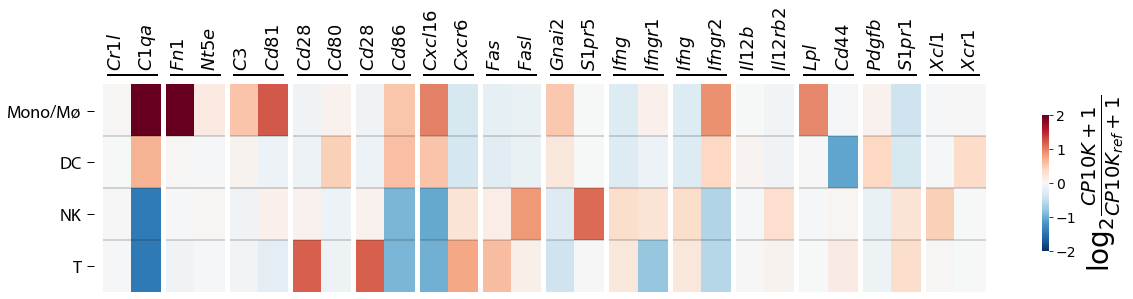

In [7]:
heat_genes = ['Cr1l', 'C1qa', 'Fn1', 'Nt5e', 'C3', 'Cd81', 'Cd28', 'Cd80', 'Cd28', 'Cd86', 'Cxcl16', 'Cxcr6', 'Fas', 'Fasl', 'Gnai2', 'S1pr5', 'Ifng', 'Ifngr1', 'Ifng', 'Ifngr2', 'Il12b', 'Il12rb2', 'Lpl', 'Cd44', 'Pdgfb', 'S1pr1','Xcl1','Xcr1']
heat_states = ['tMoMac', 'tDC','tNK cells', 'tT cells']

# find state averages for relevant genes
marker_heat = rz.centroids('Cell type', rzdata[:, heat_genes]) # heat genes are the genes you want to plot and in what order 

#compute fold changes using median as the reference
#use mean expression / normalization factor as epsilon
heat = marker_heat + rzdata.X.sum(1).mean()/1e4 # Marius: how Rapo and I calculate an optimal alpha/pseudo value to add
heat = heat.loc[heat_states, :] # you want to order the states in a specific order 
heat = heat/heat.median(0) # 
heat = np.log2(heat)
# Print these values to set vmin and vmax in the heatmap (they have to be symmetric see below)
print(heat.min().min()) 
print(heat.max().max())


fig, ax = plt.subplots(1, figsize=(20, 4))

#store fold changes, rename states for labels
rz_lfc = deepcopy(heat)
rz_lfc.index = rz_lfc.index.map({'tMoMac' : 'Mono/Mø', 'tDC' : 'DC', 'tNK cells' : 'NK', 'tT cells' : 'T'})


# heatmap using a [-2,2] colorbar 
cm = sns.heatmap(rz_lfc, ax=ax, linewidths = 0, xticklabels = 1, yticklabels = 1, cmap = plt.cm.get_cmap('RdBu_r'), 
                    vmin = -2, vmax = 2, cbar_kws={'label': r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$',
                                                   'shrink' : 0.625}) # here you indicate a symmetric vmin and vmax 
                    #cbar_pos = (.12, .25, .03, 0.5)) # you don't want to cluster in this case as you determine the orders

ax.set_ylim((ax.get_ylim()[0], -0.2))
ax.set_xlim((-0.2, ax.get_xlim()[1]))
    

# division lines for heatmap    
for x in range(1,4):
    ax.axhline(x, 0.2/28, 1, linewidth=1.5, c='k', alpha=0.2)    
    

for x in range(0,len(heat_genes),2):
    epsilon = 0.25
    ax.axhline(-0.2, (x+0.2)/len(heat_genes) + (epsilon - 0.008*x)/len(heat_genes), (x+2.2)/len(heat_genes) - (epsilon + 0.008*x)/len(heat_genes), linewidth=3, c='k')
    ax.axvline(x, 0, 2, linewidth=5, c='w') #todo: remove alpha


# gene labels
#Tick label formatting. This was edited by hand to show human analogs of the genes represented.
ax.set_xticklabels([r'$\mathit{'+tick._text+'}$' for tick in ax.get_xticklabels()])

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



# set font
    
for label in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    label.set_fontproperties('Myriad Pro')

    
# label format

ax.xaxis.set_tick_params(labelsize=18, labelrotation=90, pad=0)
ax.yaxis.set_tick_params(labelsize=18, labelrotation=0, width=1, length=7, pad=5)


# style ticks for colorbar

cbar = ax.collections[0].colorbar
# # here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)
ax.figure.axes[-1].yaxis.label.set_size(28)




plt.show()

#save fig
#fig.savefig('/n/groups/klein/nico/blz/figures/201020/heatmap_markers_rz.pdf', dpi = 400, bbox_inches = 'tight')


#save data from heatmap to export into scatterplot
rz_lfc = heat
rz_lfc.index = rz_lfc.index.map({'tMoMac' : 'Monocytes/Macrophages', 'tDC' : 'Dendritic cells', 'tNK cells' : 'NK cells', 'tT cells' : 'T cells'})
rz_lfc = rz_lfc.reset_index().melt(id_vars='index', value_name='lfc')

## Mouse fold changes (no heatmap)

In [8]:
# create a dummy heatmap to replicate current figure from paper. 
# Not necessary to match paper aesthetics.

heat_states = ['Monocytes/Macrophages', 'Dendritic cells', 'NK cells', 'T cells']

#set up boolean mask to filter non-relevant cells (i.e. non-vehicle, not classified)
nan_mask = ~blzdata.obs['Major cell type'].isna()
vehicle_mask = blzdata.obs.condition == 'Vehicle'

#find average expression for relevant genes
marker_heat = rz.centroids('Major cell type', blzdata[nan_mask & vehicle_mask, heat_genes]) # heat genes are the genes you want to plot and in what order 

#compute fold changes using median as ref
#use mean expression / normalization factor as epsilon
heat = marker_heat + blzdata[nan_mask & vehicle_mask].X.sum(1).mean()/1e4 # adata.X.sum(1).mean()/1e4 is how Rapo and I calculate an optimal alpha/pseudo value to add
heat = heat.loc[heat_states, :] # you want to order the states in a specific order 
heat = heat/heat.median(0) # 
heat = np.log2(heat)
# Print these values to set vmin and vmax in the heatmap (they have to be symmetric see below)
print(heat.min().min()) 
print(heat.max().max())

#store fold changes
blz_lfc = deepcopy(heat)
blz_lfc.columns.name = None

# plot for replication purposes: not displayed in paper

# fig, ax = plt.subplots(1, figsize=(20, 4))
# cm = sns.heatmap(blz_lfc, ax=ax, linewidths = 0, xticklabels = 1, yticklabels = 1, cmap = plt.cm.get_cmap('RdBu_r'), 
#                     vmin = -2, vmax = 2, cbar_kws={'label': r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$'}) # here you indicate a symmetric vmin and vmax 

# # division lines for hmap
# for x in range(0,30,2):
#     ax.axvline(x, 0, 2, linewidth=5, c='w')
#     ax.axhline(0, x, x+1, linewidth=5, c='k')

# ax.xaxis.tick_top() # x axis on top
# ax.xaxis.set_label_position('top')

# #style axis ticks
# ax.xaxis.set_tick_params(labelsize=14, labelrotation=90)
# ax.yaxis.set_tick_params(labelsize=14)

# ax.set_xlabel('')

# cbar = ax.collections[0].colorbar
# # # here set the labelsize by 20
# cbar.ax.tick_params(labelsize=14)
# ax.figure.axes[-1].yaxis.label.set_size(28)

# plt.show()



#save fig
#fig.savefig('/n/groups/klein/nico/blz/figures/201008/heatmap_markers_blz.pdf', dpi = 400, bbox_inches = 'tight')

#save fold changes to compare in scatterplot
blz_lfc = blz_lfc.reset_index().melt(id_vars='index', value_name='lfc')

-0.90814066
3.7291088


# Scatterplot  (3D)

In [9]:
# set up annotation function

# what pairs of genes-states to highlight
highlighted_genes = [('Il12b', 'Dendritic cells'),
                    ('Il12rb2', 'NK cells'), ('Il12rb2', 'T cells'),
                    ('Ifng', 'NK cells'), ('Ifng', 'T cells'),
                    ('Ifngr1', 'Monocytes/Macrophages'),
                    ('Ifngr2', 'Monocytes/Macrophages'), ('Ifngr2', 'Dendritic cells'),
                    ('Cd28', 'NK cells'),  ('Cd28', 'T cells'),
                    ('Cd80', 'Dendritic cells'),
                    ('Cd86', 'Dendritic cells'),
                    ('Cxcr6', 'T cells'),
                    ('Cxcl16', 'Dendritic cells'),
                    ('Xcl1', 'NK cells'), ('Xcl1', 'T cells'),
                    ('Xcr1', 'Dendritic cells')]

# hard coded palette from paper
ctype_colors = {'Monocytes/Macrophages' : '#e59257', 'Dendritic cells' : '#9f98f8', 'NK cells' : '#35663a', 'T cells' : '#7db956'}


import matplotlib.patheffects as PathEffects


from adjustText import adjust_text
def print_outliers(row):
    text_labels = []

    # for each pair of gene-state that is among the highlights:
    if (row[1], row[0]) in highlighted_genes:
        # annotate mouse and human label
        gene_label = row[1].upper()+'/'+row[1]
        text_labels.append(ax.text(row[2], row[3],  '$\mathit{%s}$' %gene_label, fontsize=30, color = ctype_colors[row[0]], fontname='Myriad Pro'))
        text_labels[-1].set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    return text_labels

In [10]:
# merge fold changes from human and mice
all_lfc = rz_lfc.merge(blz_lfc, on=['index', 'variable'], suffixes = ('_rz', '_blz'))
all_lfc= all_lfc.drop_duplicates()

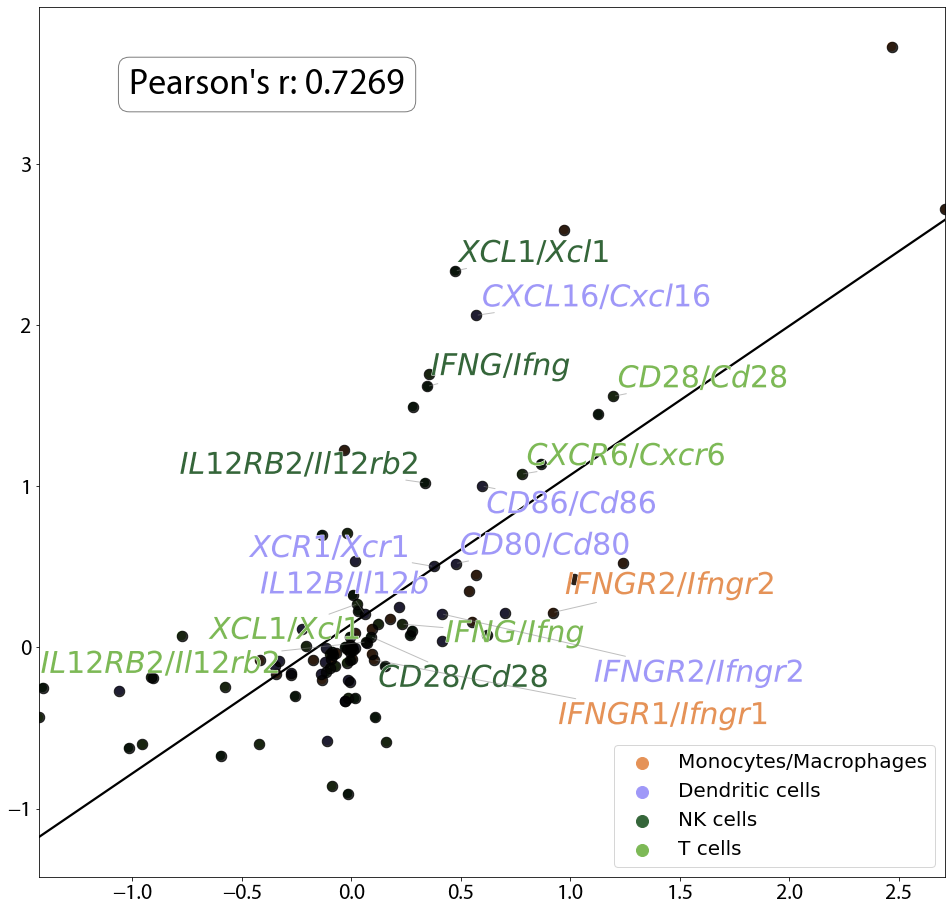

In [11]:
fig, ax = plt.subplots(1, figsize=(16.25,16))

# scatter + regplot. Colored dots hiden behind black ones to set up legend for annotations
sns.scatterplot(data = all_lfc, x = 'lfc_rz', y = 'lfc_blz', hue='index', ax = ax, s=100, palette = ctype_colors.values())
rp = sns.regplot(data = all_lfc, x = 'lfc_rz', y = 'lfc_blz', ax = ax, color='k', scatter_kws={'s': 110}, ci= None)


for label in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    label.set_fontproperties('Myriad Pro')

    
ax.set_xlabel('')    
ax.set_ylabel('')

# Mikael edits axis labels manually:
 
#ax.set_xlabel(r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$ - Zilionis et. al. (2019)', size=28, fontname='Myriad Pro')
#ax.set_ylabel(r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$ - BLZ', size=28, fontname='Myriad Pro')
ax.tick_params(labelsize=22)

plt.legend(fontsize=14)

#legend formatting
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], fontsize=20, loc='lower right', markerscale=2)

# Linear fit, Pearson's r
slope, intercept, r_value, p_value, std_err = stats.linregress(x=all_lfc['lfc_rz'], y=all_lfc['lfc_blz'])

# location of correlation box
correl_box_xy = ((ax.get_xlim()[1] - ax.get_xlim()[0])*0.10+ax.get_xlim()[0],
                (ax.get_ylim()[1] - ax.get_ylim()[0])*0.90+ax.get_ylim()[0])

correl_box = ax.text(*correl_box_xy, "Pearson's r: {}".format(round(r_value,4)), fontsize=36, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
                    fontdict={'family': 'Myriad Pro'})


#annotate highlights
adjust_text([t[0] for t in all_lfc.apply(print_outliers,axis=1) if t != []],
           arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5))

#save figure
#fig.savefig('/n/groups/klein/nico/blz/figures/201021/scatter_lfc_blz_rz_reg_highlights.pdf', dpi = 400, bbox_inches = 'tight')

plt.show()

# Second task, for figure S5 : NK/T vs DC1/2/3 (analogous analysis as before)

## Human fold changes

-1.6991225
2.0188608


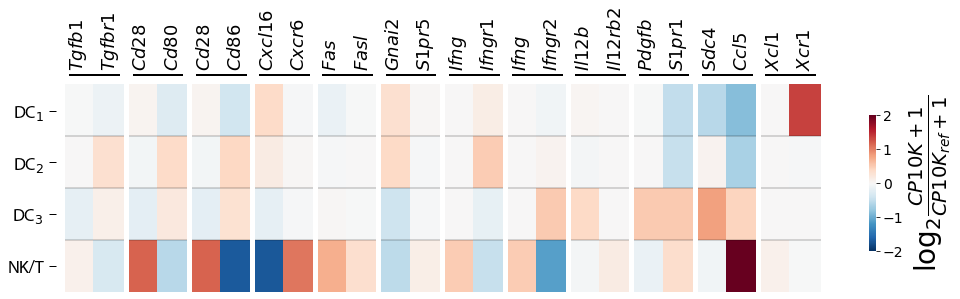

In [12]:
#relevant mouse genes (alongside their human orthologs)
heat_genes = ['Tgfb1', 'Tgfbr1', 'Cd28', 'Cd80', 'Cd28', 'Cd86', 'Cxcl16', 'Cxcr6', 'Fas', 'Fasl', 'Gnai2', 'S1pr5', 'Ifng', 'Ifngr1', 'Ifng', 'Ifngr2', 'Il12b', 'Il12rb2', 'Pdgfb', 'S1pr1', 'Sdc4', 'Ccl5',
 'Xcl1','Xcr1']
# relevant states from human patients
heat_states = ['tDC1', 'tDC2', 'tDC3','tTNK cells']

#find avg expression of relevant genes per annotated state
marker_heat = rz.centroids('Cell_type_s5', rzdata[:, heat_genes]) # heat genes are the genes you want to plot and in what order 

#compute fold changes using median as ref
# use mean/ normalization constant as epsilon
heat = marker_heat + rzdata.X.sum(1).mean()/1e4 # adata.X.sum(1).mean()/1e4 is how Rapo and I calculate an optimal alpha/pseudo value to add
heat = heat.loc[heat_states, :] # you want to order the states in a specific order 
heat = heat/heat.median(0) # 
heat = np.log2(heat)

# Print these values to set vmin and vmax in the heatmap (they have to be symmetric see below)
print(heat.min().min()) 
print(heat.max().max())


fig, ax = plt.subplots(1, figsize=(len(heat_genes)*5/7, 4))

#save human fold changes
rz_lfc = deepcopy(heat)
#rename states
rz_lfc.index = rz_lfc.index.map({'tDC1' : 'DC$_{1}$', 'tDC2' : 'DC$_{2}$', 'tDC3' : 'DC$_{3}$', 'tTNK cells' : 'NK/T'})

#heatmap
cm = sns.heatmap(rz_lfc, ax=ax, linewidths = 0, xticklabels = 1, yticklabels = 1, cmap = plt.cm.get_cmap('RdBu_r'), 
                    vmin = -2, vmax = 2, cbar_kws={'label': r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$',
                                                   'shrink' : 0.625}) # here you indicate a symmetric vmin and vmax 
        
# axis limits    
ax.set_ylim((ax.get_ylim()[0], -0.2))
ax.set_xlim((-0.2, ax.get_xlim()[1]))
    
#division lines 
for x in range(1,4):
    ax.axhline(x, 0.2/len(heat_genes), 1, linewidth=1.5, c='k', alpha=0.2)    
    
for x in range(0,len(heat_genes),2):
    epsilon = 0.25
    ax.axhline(-0.2, (x+0.2)/len(heat_genes) + (epsilon - 0.008*x)/len(heat_genes), (x+2.2)/len(heat_genes) - (epsilon + 0.008*x)/len(heat_genes), linewidth=3, c='k')
    ax.axvline(x, 0, 2, linewidth=5, c='w') #todo: remove alpha


#Tick label formatting. This was edited by hand to show human analogs of the genes represented.
ax.set_xticklabels([r'$\mathit{'+tick._text+'}$' for tick in ax.get_xticklabels()])

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

#ax.xaxis.tick_top() # x axis on top
#ax.xaxis.set_label_position('top')



#label font    
for label in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    label.set_fontproperties('Myriad Pro')

#axis tick parameters    
ax.xaxis.set_tick_params(labelsize=18, labelrotation=90, pad=0)
ax.yaxis.set_tick_params(labelsize=18, labelrotation=0, width=1, length=7, pad=5)


#colorbar formatting
cbar = ax.collections[0].colorbar
# # here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)
ax.figure.axes[-1].yaxis.label.set_size(28)




plt.show()


#save figure
#fig.savefig('/n/groups/klein/nico/blz/figures/201020/heatmap_markers_rz_dcnkt.pdf', dpi = 400, bbox_inches = 'tight')

#rz_lfc = heat
#rz_lfc.index = rz_lfc.index.map({'tDC1' : 'DC$_{1}$', 'tDC2' : 'DC$_{2}$', 'tDC3' : 'DC$_{3}$', 'tTNK cells' : 'NK/T'})

#save fold changes
rz_lfc = rz_lfc.reset_index().melt(id_vars='index', value_name='lfc')

## Mouse fold changes (no heatmap)

In [13]:
heat_states = ['DC1', 'DC2', 'DC3', 'NKT']
# You want to combine human and vehicle mouse Blz in the same marker_heat variable 
# because you want to normalize them by the median of the heatmap (the Ref Allon wrote about)
# Therefore, I would also normalize human Zilionis to 10,000 counts 
# Run centroids twice and then do a pandas combination operation

#nan_mask = ~blzdata.obs['minor_subset_s5'].isna()
vehicle_mask = blzdata.obs.condition == 'Vehicle'

marker_heat = rz.centroids('minor_subset_s5', blzdata[nan_mask & vehicle_mask, heat_genes]) # heat genes are the genes you want to plot and in what order 

#compute fold changes using median as ref
# use mean/ normalization constant as epsilon

heat = marker_heat + blzdata[nan_mask & vehicle_mask].X.sum(1).mean()/1e4 # adata.X.sum(1).mean()/1e4 is how Rapo and I calculate an optimal alpha/pseudo value to add
heat = heat.loc[heat_states, :] # you want to order the states in a specific order 

heat = heat/heat.median(0) # 
heat = np.log2(heat)


blz_lfc = deepcopy(heat)
blz_lfc.columns.name = None
blz_lfc.index = blz_lfc.index.map({'DC1' : 'DC$_{1}$', 'DC2' : 'DC$_{2}$', 'DC3' : 'DC$_{3}$', 'NKT' : 'NK/T'})


# plot for replication purposes: not displayed in paper

# fig, ax = plt.subplots(1, figsize=(20, 4))

# cm = sns.heatmap(blz_lfc, ax=ax, linewidths = 0, xticklabels = 1, yticklabels = 1, cmap = plt.cm.get_cmap('RdBu_r'), 
#                     vmin = -2, vmax = 2, cbar_kws={'label': r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$'}) # here you indicate a symmetric vmin and vmax 
#                     #cbar_pos = (.12, .25, .03, 0.5)) # you don't want to cluster in this case as you determine the orders

# for x in range(0,30,2):
#     ax.axvline(x, 0, 2, linewidth=5, c='w')
#     ax.axhline(0, x, x+1, linewidth=5, c='k')

# ax.xaxis.tick_top() # x axis on top
# ax.xaxis.set_label_position('top')


# ax.xaxis.set_tick_params(labelsize=14, labelrotation=90)
# ax.yaxis.set_tick_params(labelsize=14)

# ax.set_xlabel('')

# cbar = ax.collections[0].colorbar
# # # here set the labelsize by 20
# cbar.ax.tick_params(labelsize=14)
# ax.figure.axes[-1].yaxis.label.set_size(28)

# plt.show()


#fig.savefig('/n/groups/klein/nico/blz/figures/201008/heatmap_markers_blz.pdf', dpi = 400, bbox_inches = 'tight')


blz_lfc = blz_lfc.reset_index().melt(id_vars='index', value_name='lfc')

In [14]:
# Annotation function for second scatterplot from fig. S5

highlighted_genes = [('Il12b', 'DC$_{1}$'), ('Il12b', 'DC$_{2}$'), ('Il12b', 'DC$_{3}$'),
                    ('Il12rb2', 'NK/T'),
                    ('Ifng', 'NK/T'),
                    ('Ifngr2', 'DC$_{1}$'), ('Ifngr2', 'DC$_{2}$'), ('Ifngr2', 'DC$_{3}$'),
                    ('Cd28', 'NK/T'),
                    ('Cd80', 'DC$_{1}$'), ('Cd80', 'DC$_{2}$'), ('Cd80', 'DC$_{3}$'),
                    ('Cd86', 'DC$_{1}$'), ('Cd86', 'DC$_{2}$'), ('Cd86', 'DC$_{3}$'),
                    ('Cxcr6', 'NK/T'),
                    ('Cxcl16', 'DC$_{1}$'), ('Cxcl16', 'DC$_{2}$'), ('Cxcl16', 'DC$_{3}$'),
                    ('Xcl1', 'NK/T cells'),
                    ('Xcr1', 'DC$_{1}$'), ('Xcr1', 'DC$_{2}$'), ('Xcr1', 'DC$_{3}$')]

ctype_colors = {'DC$_{1}$' : '#e73c23', 'DC$_{2}$' : '#ee9c38', 'DC$_{3}$' : '#8e2111', 'NK/T' : '#35673b'}

import matplotlib.patheffects as PathEffects



from adjustText import adjust_text
def print_outliers(row):
    text_labels = []

    
    if (row[1], row[0]) in highlighted_genes:
    
        gene_label = row[1].upper()+'/'+row[1]
        
        text_labels.append(ax.text(row[2], row[3], '$\mathit{%s}$' %gene_label, fontsize=30, color = ctype_colors[row[0]], fontname='Myriad Pro'))
        text_labels[-1].set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    return text_labels

## Scatterplot (S5)

In [15]:
# merge fold changes from human and mice
all_lfc = rz_lfc.merge(blz_lfc, on=['index', 'variable'], suffixes = ('_rz', '_blz'))
all_lfc= all_lfc.drop_duplicates()

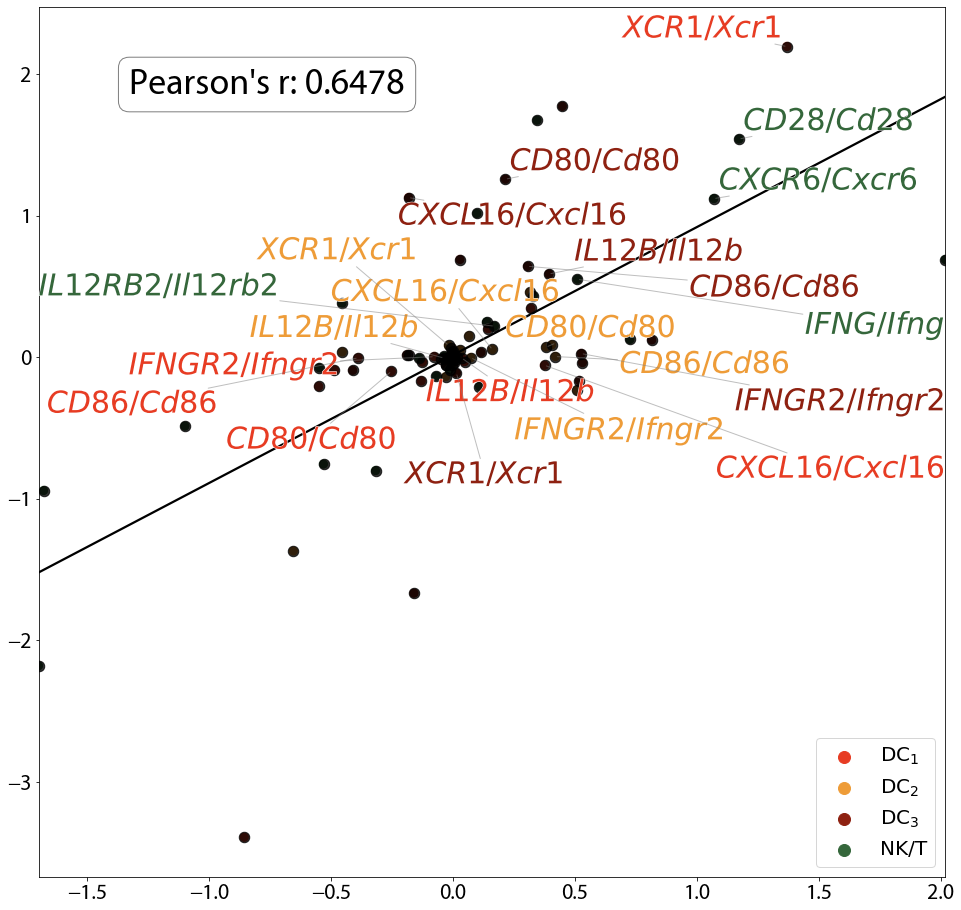

In [16]:
fig, ax = plt.subplots(1, figsize=(16.25,16))

# scatter + regplot. Colored dots hiden behind black ones to set up legend for annotations
sns.scatterplot(data = all_lfc, x = 'lfc_rz', y = 'lfc_blz', hue='index', ax = ax, s=100, palette = ctype_colors.values())
rp = sns.regplot(data = all_lfc, x = 'lfc_rz', y = 'lfc_blz', ax = ax, color='k', scatter_kws={'s': 110}, ci= None)


for label in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    label.set_fontproperties('Myriad Pro')

    
ax.set_xlabel('')    
ax.set_ylabel('')
    

#labels added manually
#ax.set_xlabel(r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$ - Zilionis et. al. (2019)', size=28, fontname='Myriad Pro')
#ax.set_ylabel(r'$\log _{2} \frac{CP10K+1}{CP10K_{ref}+1}$ - BLZ', size=28, fontname='Myriad Pro')
ax.tick_params(labelsize=22)

plt.legend(fontsize=14)

# set up legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], fontsize=20, loc='lower right', markerscale=2)

#linear fit, Pearson's r correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(x=all_lfc['lfc_rz'], y=all_lfc['lfc_blz'])

#correlation box in the plot
correl_box_xy = ((ax.get_xlim()[1] - ax.get_xlim()[0])*0.10+ax.get_xlim()[0],
                (ax.get_ylim()[1] - ax.get_ylim()[0])*0.90+ax.get_ylim()[0])


correl_box = ax.text(*correl_box_xy, "Pearson's r: {}".format(round(r_value,4)), fontsize=36, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
                    fontdict={'family': 'Myriad Pro'})

# gene annotations
adjust_text([t[0] for t in all_lfc.apply(print_outliers,axis=1) if t != []], arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5))


#fig.savefig('/n/groups/klein/nico/blz/figures/201021/scatter_lfc_blz_rz_reg_highlights_dcnkt.pdf', dpi = 400, bbox_inches = 'tight')

plt.show()